# 1. Problem Description 

In this notebook we will try to build a spam detector. Let's imagine that you're having an e-mail. Some mails are worth reading, and some of them are just spam, and we don't want them to be in our inbox. We will try to build a dectector to clasiffy which of the mail is spam and which of them is not a spam. The whole description of the dataset is just under this link: "https://www.kaggle.com/datasets/nitishabharathi/email-spam-dataset/data"

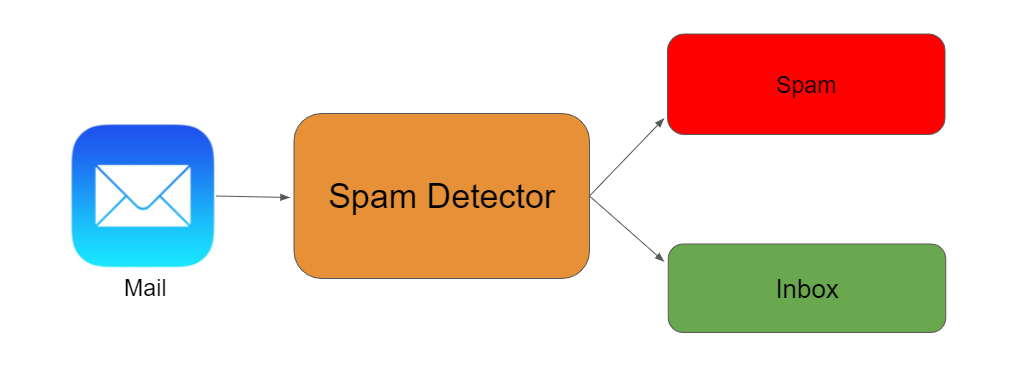

In [2]:
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

im = Image.open(requests.get('https://miro.medium.com/v2/resize:fit:1400/0*mbFBPcPUJD-53v3h.png', stream=True).raw)
display(im)

# 2. Imports for Data Cleansing and Visualising

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk 


In [4]:
sns.set_style('whitegrid')
pd.set_option('display.max_columns',40)
pd.set_option('display.width',320)
sns.set_palette('dark')

# 3. Importing the Data

In [5]:
main_data = pd.read_csv('completeSpamAssassin.csv')

# 4. Data Cleansing and Feature Engineering

4.1 Checking the Null Values.

In [6]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


In [7]:
main_data.isnull().sum()

Unnamed: 0    0
Body          1
Label         0
dtype: int64

In [8]:
main_data[main_data['Body'].isnull()]

,Unnamed: 0,Body,Label
328,328,NaN,1


In [9]:
main_data = main_data[~main_data['Body'].isnull()]
main_data = main_data.drop('Unnamed: 0', axis=1)

4.2 Fixing the Data Quality in "Body" column.

4.2.1 Deleting the "/n".


In [10]:
main_data['Body'].head(5)

0    \nSave up to 70% on Life Insurance.\nWhy Spend...
1    1) Fight The Risk of Cancer!\nhttp://www.adcli...
2    1) Fight The Risk of Cancer!\nhttp://www.adcli...
3    ##############################################...
4    I thought you might like these:\n1) Slim Down ...
Name: Body, dtype: object

In [11]:
main_data['Body'] = [x.replace('\n','') for x in main_data['Body']]

main_data['Body'] = [" ".join(x.split()) for x in main_data['Body']] # Removing the unnecesarry whitespaces between words.


In [12]:
main_data.loc[4221]['Body']

'URL: http://www.newsisfree.com/click/-0,8613662,159/Date: 2002-10-06T18:12:58+01:00In 1986, we in the U.S. were playing the Nintendo Entertainment System (known as the Famicom in Japan), and roughly a third of the music for its first set of games was written by Hirokazu "Hip" Tanaka, then with Nintendo Co. Ltd.He has written music for countless other games as well as designing the Game Boy Camera and Printer, and also scored the soundtrack to the Pokemon TV series. Alexander Brandon catches up with the legendary composer.'

4.2.2 Checking numbers of links in an Email.

In [13]:
pattern = 'http://\w*\.{0,1}\w*\.{0,1}\w*'
http_list = []

for word in main_data['Body']:
    test = ','.join(re.findall(pattern,word))
    if len(test) == 0:
        http_list.append("None")
    else:
        http_list.append(test)

#
num_of_links = []
for item in http_list:
    if item == 'None':
        num_of_links.append(0)
    else:
        item = item.split(',')
        num_of_links.append(len(item))


main_data['Num of Links'] = num_of_links

4.2.3 Checking if a popular mails are within the mail massage.

In [14]:
popular_mails = ['gmail', 'outlook','hotmail','aol.com','aim.com','yahoo','titan','icloud','protonmail','pm.com','zoho.com',
                 'yandex.com','gmx.com','hubspot.com','mail.com','tutanota.com']


mails_pattern = '|'.join(popular_mails)

main_data['Contains Mail'] = main_data['Body'].str.contains(mails_pattern).astype('int')


main_data

,Body,Label,Num of Links,Contains Mail
0,Save up to 70% on Life Insurance.Why Spend Mor...,1,0,0
1,1) Fight The Risk of Cancer!http://www.adclick...,1,7,0
2,1) Fight The Risk of Cancer!http://www.adclick...,1,6,0
3,##############################################...,1,6,0
4,I thought you might like these:1) Slim Down - ...,1,5,0
...,...,...,...,...
6041,empty,0,0,0
6042,___ ___ ___ /\ \ /\ \ /\ \ ___ |::\ \ \:\ \ /:...,0,29,0
6043,IN THIS ISSUE:01. Readers write02. Extension s...,0,10,0
6044,empty,0,0,0


4.2.4 Checking number of words.

In [15]:

main_data['Number of Words'] = [len(nltk.word_tokenize(x)) for x in main_data['Body']]

main_data.head(5)

,Body,Label,Num of Links,Contains Mail,Number of Words
0,Save up to 70% on Life Insurance.Why Spend Mor...,1,0,0,188
1,1) Fight The Risk of Cancer!http://www.adclick...,1,7,0,130
2,1) Fight The Risk of Cancer!http://www.adclick...,1,6,0,107
3,##############################################...,1,6,0,668
4,I thought you might like these:1) Slim Down - ...,1,5,0,98


4.2.5 Checking the lenght of the message.

In [16]:
main_data['Mail Len'] = [len(x) for x in main_data['Body']]

main_data.head(5)



,Body,Label,Num of Links,Contains Mail,Number of Words,Mail Len
0,Save up to 70% on Life Insurance.Why Spend Mor...,1,0,0,188,968
1,1) Fight The Risk of Cancer!http://www.adclick...,1,7,0,130,741
2,1) Fight The Risk of Cancer!http://www.adclick...,1,6,0,107,602
3,##############################################...,1,6,0,668,2666
4,I thought you might like these:1) Slim Down - ...,1,5,0,98,630


4.2.6 Checking the amout of sentences in a mail.

In [17]:
main_data['Number of Sentences'] = [len(nltk.sent_tokenize(x)) for x in main_data['Body']]

main_data.head()

,Body,Label,Num of Links,Contains Mail,Number of Words,Mail Len,Number of Sentences
0,Save up to 70% on Life Insurance.Why Spend Mor...,1,0,0,188,968,10
1,1) Fight The Risk of Cancer!http://www.adclick...,1,7,0,130,741,1
2,1) Fight The Risk of Cancer!http://www.adclick...,1,6,0,107,602,1
3,##############################################...,1,6,0,668,2666,28
4,I thought you might like these:1) Slim Down - ...,1,5,0,98,630,2


# SPRAWDZ SREDNIA DLUGOSC MAILA I INNE STATYSTYKi !!! 

# 5. Data Visualisation

5.1 General Distribution of Spam & Ham

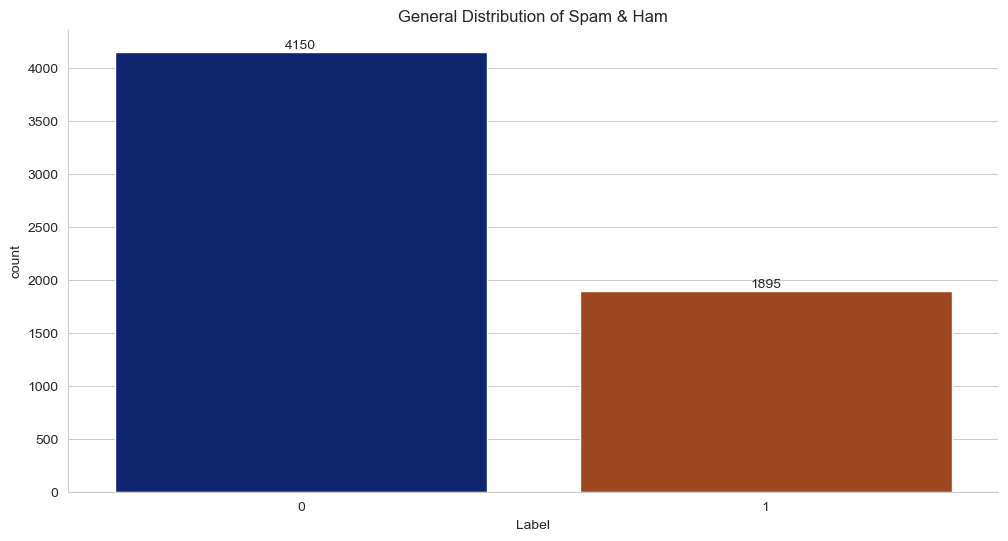

In [18]:
plt.figure(figsize=(12,6))

ax = sns.countplot(data=main_data, x='Label')

for count in ax.containers:
    ax.bar_label(count);

sns.despine()
plt.title("General Distribution of Spam & Ham");

We can see that, most of our mails were Hams. About 34% of all mails, were considered as spam.

Let's check if Number of Links in an email determines, if a particular message is a spam.

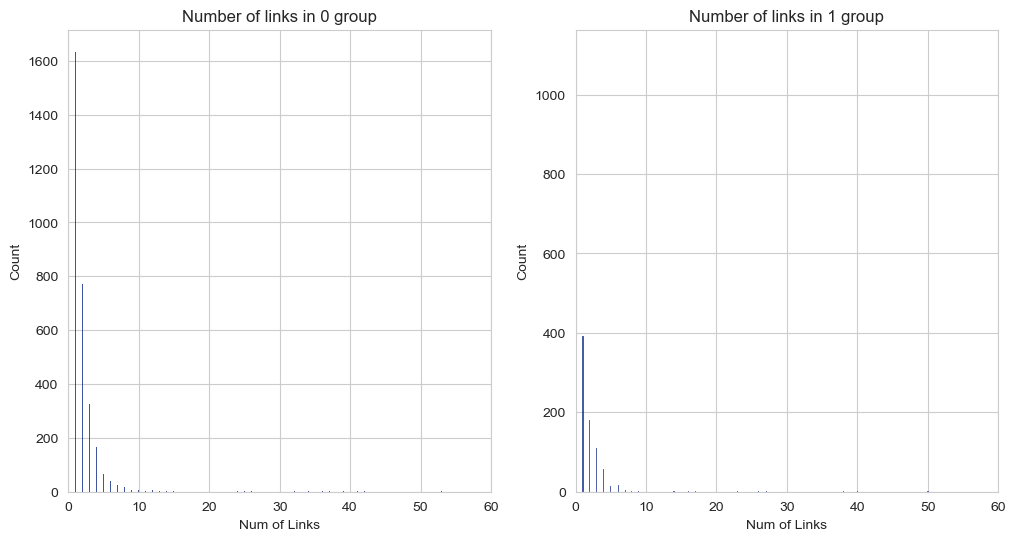

In [19]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6),sharex=False, sharey=False)

for i in range(0,2):
    sns.histplot(data=main_data[main_data['Label']==i], x='Num of Links', ax=axes[i])
    axes[i].set_title(f"Number of links in {i} group")
    axes[i].set_xlim(0,60)

In [20]:
main_data[main_data['Num of Links']!=0].groupby('Label')['Num of Links'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,3114.0,3.365125,56.312508,1.0,1.0,1.0,2.0,3131.0
1,787.0,2.357052,3.967211,1.0,1.0,2.0,3.0,64.0


We can see, that having a lot of links in message, don't necessary means that a message is a spam. Meaning, that maybe it not so so good to put that variable into the model. However we can also see that, there's some kinda of outliers.

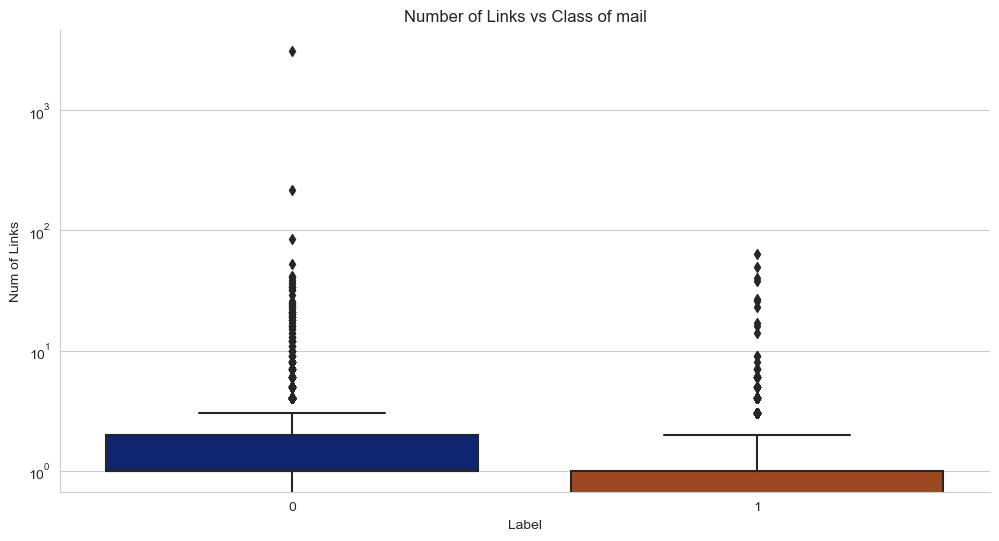

In [21]:
plt.figure(figsize=(12,6))

sns.boxplot(data=main_data, x='Label', y='Num of Links')
plt.yscale('log')
plt.title("Number of Links vs Class of mail");
sns.despine()

There's a lot of outliers in both of the groups. And also we can see, that having a lot of links, indicates, that a particular mail could not be a SPAM. Let's check how about most popular mails.

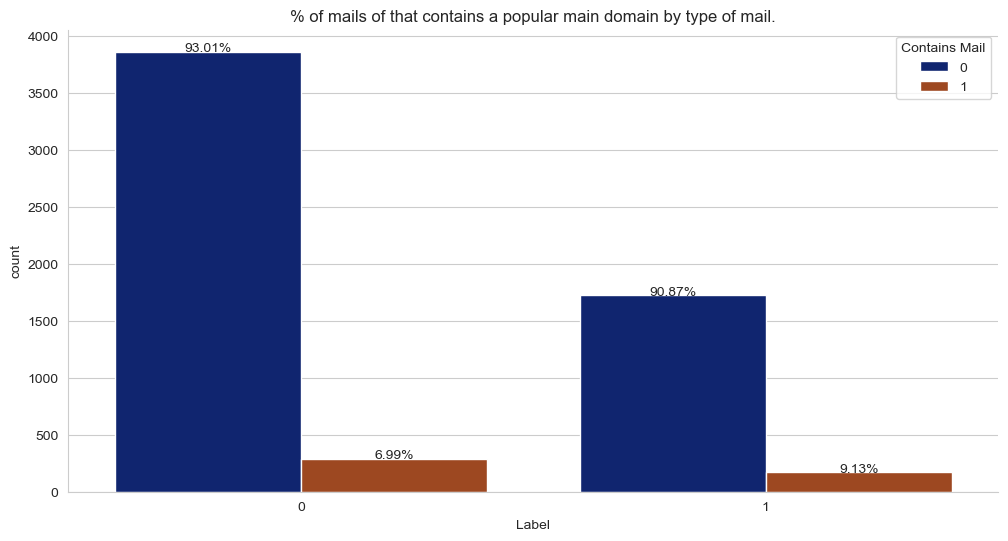

In [22]:
total_counts = main_data['Label'].value_counts()
hue_labels = list(main_data['Label'].unique())


plt.figure(figsize=(12,6))
ax = sns.countplot(data=main_data, x='Label', hue='Contains Mail')

for p in ax.patches:
    if p.get_x() > 0:
        total_value = 0
    else:
        total_value = 1
    count_value = p.get_height()
    percentage = (count_value / total_counts[hue_labels[total_value]]) * 100
    ax.annotate(f"{percentage:.2f}%",xy=(p.get_x()+0.2,count_value), ha='center')
sns.despine()
plt.title("% of mails of that contains a popular main domain by type of mail.");

    

We can see, that if the mail contains domains form most popular mails it's more likely to be a spam. Now let's check the Number of Words in a mail.

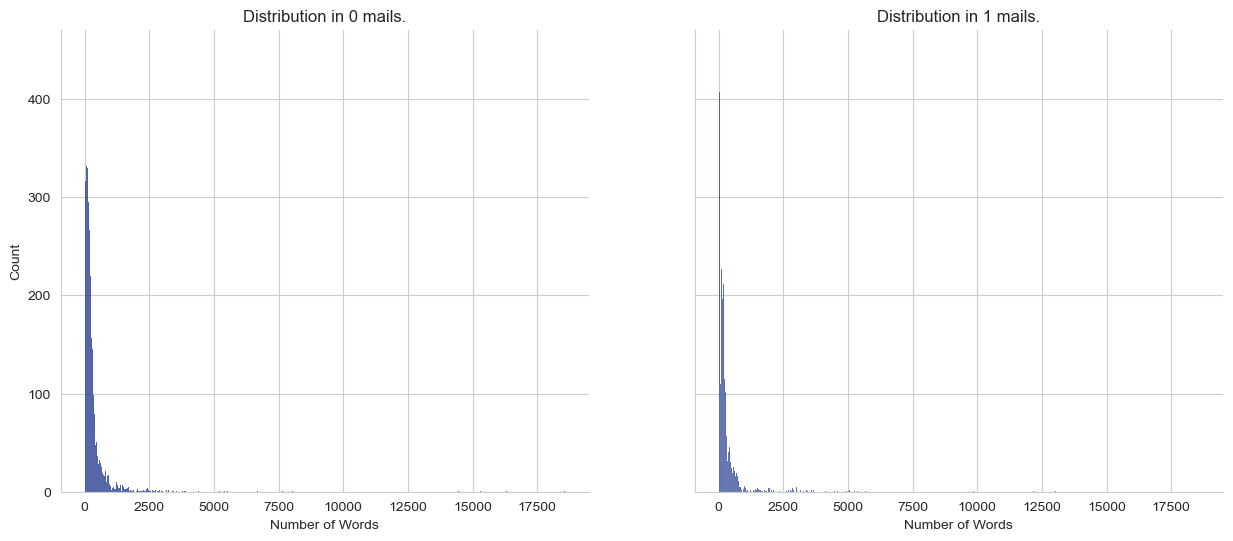

In [23]:
fig,axes = plt.subplots(ncols=2, nrows=1, figsize = (15,6), sharex=True, sharey=True)

for label in main_data['Label'].unique():
    
    sns.histplot(data = main_data[main_data['Label']==label], x='Number of Words', ax=axes[label])
    axes[label].set_title(f"Distribution in {label} mails.");

sns.despine()
    


In [24]:
main_data.groupby('Label')['Number of Words'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,4150.0,311.677349,742.493351,1.0,82.0,169.0,308.0,18571.0
1,1895.0,326.058047,748.116545,0.0,65.0,155.0,301.0,13055.0


We can see that, both of the groups have a similar distribution of Number of Words. However, we can see that, if a mails nontains a number of words between 2500 and 5000 it's more likely a spam. We can also see that we have mails that have 0 words and are considered as a spam. We will delete them from our dataset. Let's check how does it look in terms of length of the mail.

In [25]:
main_data = main_data[main_data['Number of Words']!=0]

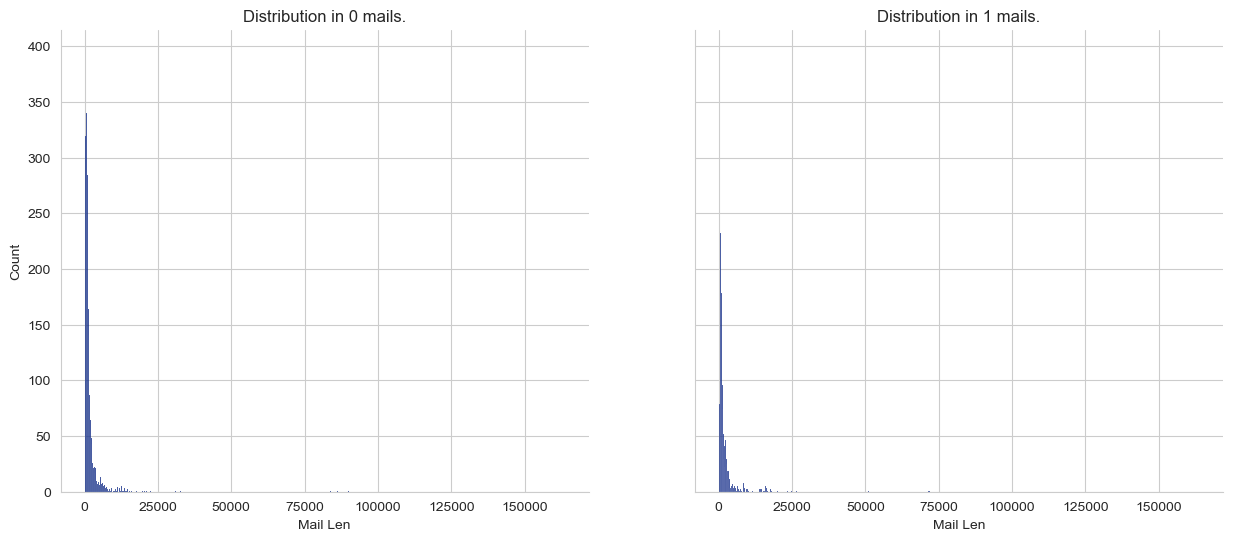

In [26]:
fig,axes = plt.subplots(ncols=2, nrows=1, figsize = (15,6), sharex=True, sharey=True)

for label in main_data['Label'].unique():
    
    sns.histplot(data = main_data[main_data['Label']==label], x='Mail Len', ax=axes[label])
    axes[label].set_title(f"Distribution in {label} mails.");

sns.despine()
    


In [27]:
main_data.groupby('Label')['Mail Len'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
0,4150.0,1633.022169,4447.601441,5.0,438.25,862.0,1540.75,163685.0
1,1892.0,1802.073467,4943.631290,4.0,386.00,843.0,1582.00,127734.0


It's looking similar to the Number of Words analysis. Now let's check the number of sentences in a mail.

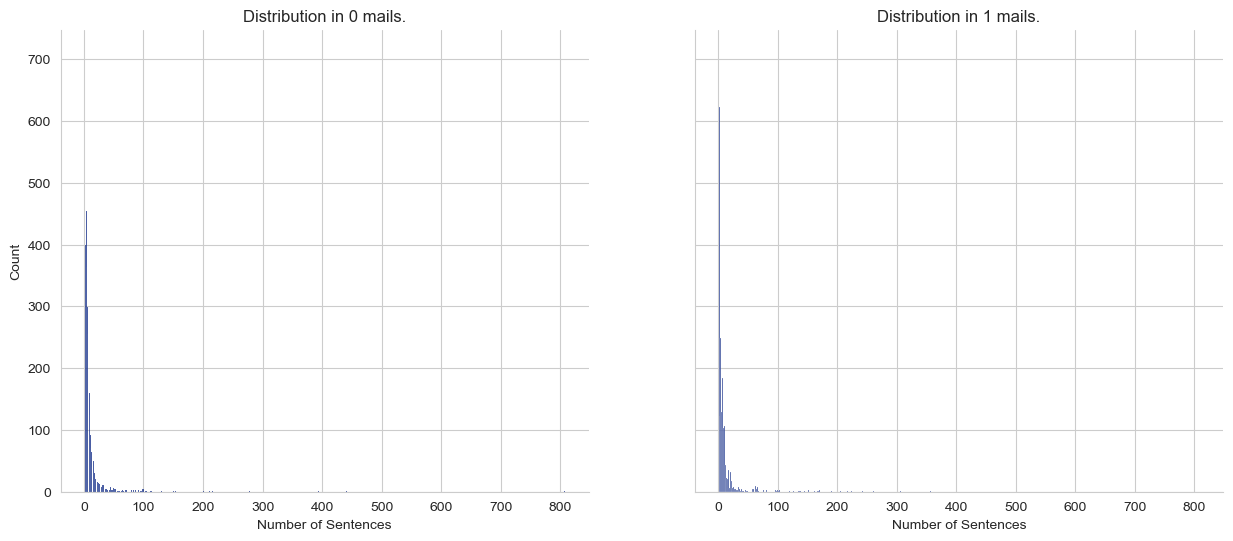

In [28]:
fig,axes = plt.subplots(ncols=2, nrows=1, figsize = (15,6), sharex=True, sharey=True)

for label in main_data['Label'].unique():
    
    sns.histplot(data = main_data[main_data['Label']==label], x='Number of Sentences', ax=axes[label])
    axes[label].set_title(f"Distribution in {label} mails.");

sns.despine()
    


We can see that there's more spam if, the number of sentences have more than 100 sentences. In the next part we will check what was the most frequent words in both Spam and Ham.

In [29]:
spam_df = main_data[main_data['Label']==1]
ham_df = main_data[main_data['Label']==0]

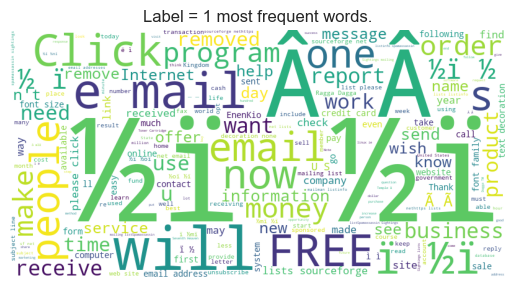

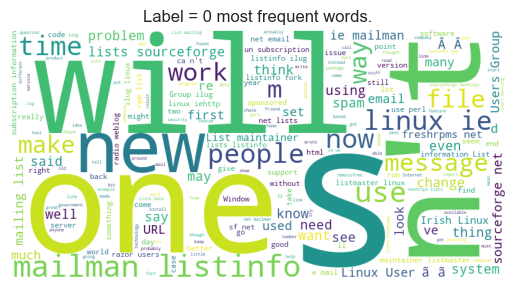

In [30]:
data_frames = [spam_df, ham_df]

for frame in data_frames:
    text = " ".join(frame['Body'])
    words = nltk.word_tokenize(text)
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        width=800,
        height=400,
        colormap='viridis'
    )

    wordcloud.generate_from_text(' '.join(words))

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"Label = {frame['Label'].unique()[0]} most frequent words.")
    plt.show()

We can see that, most popular words in both different mails are completly different. In terms of <b> Spam </b> messages, words are connected with some kinda promotion, like "Free", "Click", "Money" and many others. In terms of <b> Ham </b> messages, words are connected with work. In the next part, we will try to create TF-IDF Vectorizer to check how rare or common a particular word is.

# 6. TF-IDF Vectorizer

TF - Is the number of times a term apperars in the mails. It' calculated as: TF(t) = Number /s of times a word 't' occurs in a mail.

IDF - is a measure how common or rare a term is across the entire corups of mails. If the word is common in all mails, the IDF value (normalized) will approach as 0, if the word is rare the the IDF will be equal to 1. It's calculated as: $IDF(t) = 1 + \log_e \frac{n}{df(t)}$ where: $n$ - Total number of documents available, $t$ - term of which idf value has to be calculated, $df(t)$ - Number of documents in which the term t appears.


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer


TFIDF = TfidfVectorizer(max_features=20000, stop_words='english')

X = TFIDF.fit_transform(main_data['Body']).toarray()
y = main_data['Label']

display(TFIDF.vocabulary_) # Number of words in all of the mails.
display(TFIDF.idf_) #Non normalisef IDF values.
print(X.shape)

{'save': 15362,
 '70': 1313,
 'life': 10686,
 'insurance': 9709,
 'spend': 16342,
 'quote': 14311,
 'family': 7293,
 'financial': 7507,
 'security': 15573,
 'important': 9408,
 'savings': 15371,
 'makes': 11131,
 'buying': 3633,
 'simple': 15957,
 'affordable': 1960,
 'provide': 14116,
 'free': 7838,
 'access': 1713,
 'best': 3099,
 'companies': 4633,
 'lowest': 10942,
 'rates': 14419,
 'fast': 7331,
 'easy': 6404,
 'saves': 15365,
 'money': 11776,
 'let': 10616,
 'help': 8843,
 'started': 16474,
 'values': 18575,
 'country': 5119,
 'new': 12259,
 'coverage': 5145,
 'hundreds': 9194,
 'thousands': 17563,
 'dollars': 6115,
 'requesting': 14863,
 'service': 15701,
 'minutes': 11627,
 'complete': 4682,
 'shop': 15848,
 'compare': 4643,
 'types': 18161,
 'click': 4344,
 'protecting': 14093,
 'investment': 9858,
 'll': 10815,
 'make': 11122,
 'receipt': 14514,
 'email': 6579,
 'error': 6861,
 'wish': 19271,
 'removed': 14772,
 'list': 10772,
 'type': 18157,
 'remove': 14771,
 'reside': 1489

array([3.19639752, 3.46248896, 6.15130779, ..., 7.76074571, 7.91489639,
       9.01350868])

(6042, 20000)


# 7. Machine Learning 

In this part, we will try to fit the features to a particualar models, to see which one will provide the best results.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, recall_score


In [33]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)

In [34]:
models = [LogisticRegression(verbose=0), RandomForestClassifier(verbose=0), GradientBoostingClassifier(verbose=0),
          BernoulliNB(), MultinomialNB(), GaussianNB(), CatBoostClassifier(verbose=0)]

accuracy = []
recall = []



for model in models:
    classifier = model
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    acc = accuracy_score(y_test, prediction)
    rec = recall_score(y_test, prediction)
    accuracy.append(acc)
    recall.append(rec)

In [35]:
model_names = [str(model).split('(')[0] for model in models]

In [36]:
data = {'ModelName':model_names, 'Recall':recall, 'Accuracy':accuracy}

models_output = pd.DataFrame(data)
models_output.loc[6] = ['CatBoostClassifier',0.958609,0.949255]

In [37]:
models_output

,ModelName,Recall,Accuracy
0,LogisticRegression,0.771523,0.921677
1,RandomForestClassifier,0.942053,0.946498
2,GradientBoostingClassifier,0.759934,0.913403
3,BernoulliNB,0.763245,0.917816
4,MultinomialNB,0.740066,0.912300
5,GaussianNB,0.855960,0.918367
6,CatBoostClassifier,0.958609,0.949255


We can see that CatBoost performed the best in terms of Accuracy and Recall. Let's show the classification report and confusion matrix for that model.

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1209
           1       0.90      0.96      0.93       604

    accuracy                           0.95      1813
   macro avg       0.94      0.95      0.94      1813
weighted avg       0.95      0.95      0.95      1813



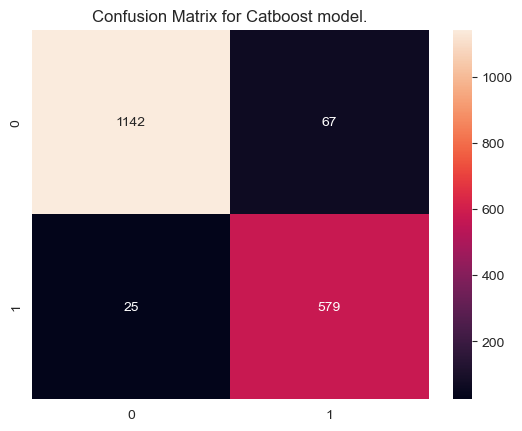

In [38]:
print(classification_report(y_test, prediction))
sns.heatmap(confusion_matrix(y_test, prediction),annot=True, fmt='g')
plt.title("Confusion Matrix for Catboost model.");

In the output we can see, that we have more False Positives than False Negatives. But in terms of this project, I assumed that having a lower False Negatives is better than having few False Positives. in the next Step we will try do upgrade the CatBoost model, to perform better.

# 8. Hyperparameter Tuning.

For parameter tuning we will use GridSearch, to try to find the best parameters.

In [60]:
model = CatBoostClassifier(
    verbose=0,
    l2_leaf_reg=0.1,
    max_depth=5,
    model_size_reg=100,
    boosting_type = 'Ordered'
)

model.fit(X_train, y_train)

#Train Pred

train_pred = model.predict(X_train)
train_recall = recall_score(y_train, train_pred)
train_accuracy = accuracy_score(y_train, train_pred)

#Test Pred

test_pred = model.predict(X_test)
test_recall = recall_score(y_test, test_pred)
test_accuracy = accuracy_score(y_test, test_pred)


print(f"Accuracy score on Train: {train_accuracy}, with Recall: {train_recall}")
print(f"Accuracy on Test: {test_accuracy}, with Recall: {test_recall}")

Accuracy score on Train: 0.9664223220619532, with Recall: 1.0
Accuracy on Test: 0.9531163816878102, with Recall: 0.9685430463576159


              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1209
           1       0.90      0.97      0.93       604

    accuracy                           0.95      1813
   macro avg       0.94      0.96      0.95      1813
weighted avg       0.96      0.95      0.95      1813



<Axes: >

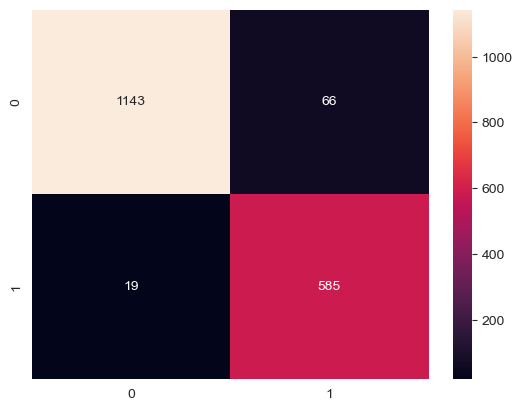

In [62]:
print(classification_report(y_test, test_pred))
sns.heatmap(confusion_matrix(y_test,test_pred),annot=True, fmt='g')

As we see, after the tuning, we have less False Negatives and False Positives. Also a 95% Accuracy is not so bad result.